In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

import renom as rm
from renom.optimizer import Sgd

In [2]:
# Datapath must point to the directory containing the mldata folder.
# data_path = "." # これではエラーになる（今までとデータの配置を変える必要がある f）
data_path = "../dataset"
mnist = fetch_mldata('MNIST original', data_home=data_path)

X = mnist.data
y = mnist.target

# Rescale the image data to 0 ~ 1.
X = X.astype(np.float32)
X /= X.max()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
labels_train = LabelBinarizer().fit_transform(y_train).astype(np.float32)
labels_test = LabelBinarizer().fit_transform(y_test).astype(np.float32)

# Training data size.
N = len(X_train)

In [3]:
class Mnist(rm.Model):

    def __init__(self):
        super(Mnist, self).__init__()
        self._layer1 = rm.Dense(100)
        self._layer2 = rm.Dense(10)
#         self._dropout1 = rm.Dropout(dropout_ratio=0.5)

    # 今回のカギとなる Dropout
    def forward(self, x):
#         t1 = self._dropout1(self._layer1(x))
        t1 = self._layer1(x)
        out = self._layer2(t1)
        return out

In [4]:
network = Mnist()

In [5]:
# Hyper parameters
batch = 64
epoch = 50

optimizer = Sgd(lr = 0.01)

learning_curve = []
test_learning_curve = []

for i in range(epoch):
    perm = np.random.permutation(N)
    loss = 0
    for j in range(0, N // batch):
        train_batch = X_train[perm[j * batch:(j + 1) * batch]]
        responce_batch = labels_train[perm[j * batch:(j + 1) * batch]]

        # The computational graph is only generated for this block:
        with network.train():
            l = rm.softmax_cross_entropy(network(train_batch), responce_batch)

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)

        # Changing type to ndarray is recommended.
        loss += l.as_ndarray()

    train_loss = loss / (N // batch)

    # Validation
    test_loss = rm.softmax_cross_entropy(network(X_test), labels_test).as_ndarray()
    test_learning_curve.append(test_loss)
    learning_curve.append(train_loss)
    if i % 2 == 0:
        print("epoch %03d train_loss:%f test_loss:%f"%(i, train_loss, test_loss))

epoch 000 train_loss:0.613114 test_loss:0.395304
epoch 002 train_loss:0.329354 test_loss:0.324205
epoch 004 train_loss:0.303095 test_loss:0.307551
epoch 006 train_loss:0.290279 test_loss:0.300460
epoch 008 train_loss:0.282259 test_loss:0.296792
epoch 010 train_loss:0.276647 test_loss:0.290076
epoch 012 train_loss:0.272332 test_loss:0.289817
epoch 014 train_loss:0.268500 test_loss:0.288110
epoch 016 train_loss:0.265784 test_loss:0.288089
epoch 018 train_loss:0.263626 test_loss:0.283075
epoch 020 train_loss:0.261100 test_loss:0.281757
epoch 022 train_loss:0.259769 test_loss:0.282089
epoch 024 train_loss:0.257814 test_loss:0.284443
epoch 026 train_loss:0.256623 test_loss:0.280694
epoch 028 train_loss:0.255255 test_loss:0.279372
epoch 030 train_loss:0.253945 test_loss:0.279496
epoch 032 train_loss:0.252702 test_loss:0.284316
epoch 034 train_loss:0.251710 test_loss:0.282060
epoch 036 train_loss:0.250622 test_loss:0.284134
epoch 038 train_loss:0.249942 test_loss:0.280005
epoch 040 train_loss

In [6]:
network.set_models(inference=True)

[[638   0   5   1   3   7   7   2   6   1]
 [  1 748   2   2   0   5   0   2   4   1]
 [  5   9 661  11   5   1  10   6   9   1]
 [  2   1  15 633   0  28   0   5  11   4]
 [  2   5   6   0 658   1   7   2   5  22]
 [  6   2   4  29   5 574  12   2   8   7]
 [  6   3   4   1   2   6 685   1   3   0]
 [  2   0  12   2   7   1   0 665   1  25]
 [  4  14  12  16   6  29   8   0 550   7]
 [  3   4   0  16  11   4   0  18   8 655]]
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95       670
        1.0       0.95      0.98      0.96       765
        2.0       0.92      0.92      0.92       718
        3.0       0.89      0.91      0.90       699
        4.0       0.94      0.93      0.94       708
        5.0       0.88      0.88      0.88       649
        6.0       0.94      0.96      0.95       711
        7.0       0.95      0.93      0.94       715
        8.0       0.91      0.85      0.88       646
        9.0       0.91      0.91      

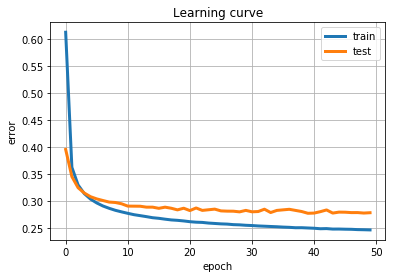

In [7]:
predictions = np.argmax(network(X_test).as_ndarray(), axis=1)

# Confusion matrix and classification report.
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_learning_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()